In [2]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import os, glob, pickle
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Reshape
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import soundfile as sf
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import soundfile
seed=7
np.random.seed(seed)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# CREATE DIRECTORY OF AUDIO FILES 
audio = "/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:10]

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10']

In [4]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
emotion = []
gender = []
actor = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [5]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
audio_df = pd.DataFrame(emotion, columns=['Emotions'])
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
#audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
#audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df.head()

# dataframe for emotion of files
#emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
#path_df = pd.DataFrame(file_path, columns=['Path'])
#Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
#Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
#Ravdess_df.head()

,Emotions,path
0,neutral,/content/drive/MyDrive/RAVDESS/audio_speech_ac...
1,neutral,/content/drive/MyDrive/RAVDESS/audio_speech_ac...
2,neutral,/content/drive/MyDrive/RAVDESS/audio_speech_ac...
3,calm,/content/drive/MyDrive/RAVDESS/audio_speech_ac...
4,calm,/content/drive/MyDrive/RAVDESS/audio_speech_ac...


In [6]:
# ENSURE GENDER,EMOTION, AND ACTOR COLUMN VALUES ARE CORRECT
pd.set_option('display.max_colwidth', -1)
audio_df.sample(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Emotions,path
810,happy,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_14/03-01-03-01-01-02-14.wav
489,neutral,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-01-01-01-01-09.wav
799,happy,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_14/03-01-03-02-02-02-14.wav
680,fear,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_12/03-01-06-02-02-01-12.wav
898,disgust,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_15/03-01-07-02-01-01-15.wav
656,angry,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_11/03-01-05-02-01-01-11.wav
978,happy,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_17/03-01-03-01-02-01-17.wav
816,disgust,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_14/03-01-07-01-02-01-14.wav
518,angry,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-05-01-02-01-09.wav
228,fear,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_04/03-01-06-01-01-01-04.wav


In [8]:
# EXPORT TO CSV
audio_df.to_csv('/content/drive/MyDrive/audio.csv')

In [9]:
# Read Data
data = pd.read_csv('/content/drive/MyDrive/audio.csv')
data.head(5)
data.shape

(1440, 3)

In [10]:
data_path = pd.concat([audio_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,path
0,neutral,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-01-01.wav
2,neutral,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav
3,calm,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-02-01.wav
4,calm,/content/drive/MyDrive/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01-01.wav


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


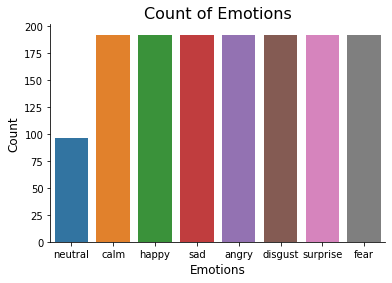

In [11]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [12]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

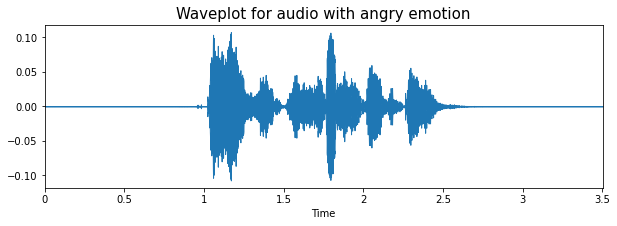

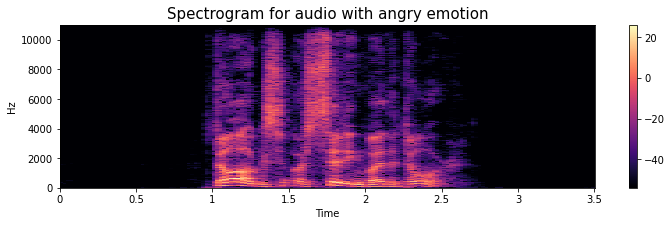

In [ ]:
emotion='angry'
path = np.array(data_path.path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [13]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def noise2(data):
    noise_amp = 0.025*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def pitch2(data, sampling_rate, pitch_factor=0.6):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
# taking any example and checking for techniques.
path = np.array(data_path.path)[1]
data, sample_rate = librosa.load(path)

In [14]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate,n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
       
    return result

In [15]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    result = np.array([])
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with noise2
    noise_data2 = noise2(data)
    res3 = extract_features(noise_data2)
    result = np.vstack((result, res3)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    # data with stretching and pitching
    new_data1 = stretch(data)
    data_stretch_pitch = pitch2(new_data1, sample_rate)
    res4 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res4)) # stacking vertically
    return result

In [16]:
X, Y = [], []
for path, emotion in zip(audio_df.path, audio_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [18]:
len(X), len(Y), data_path.path.shape

(7200, 7200, (1440,))

In [19]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,labels
0,0.300781,0.706492,0.756853,0.735217,0.731014,0.715156,0.667529,0.673754,0.722173,0.748969,0.739946,0.722562,0.685907,-646.141479,73.066620,0.403144,16.848043,9.805768,1.096762,-4.758567,-3.821855,-14.999225,-3.379040,0.610258,-3.628367,2.119565,0.002989,1.786376e-06,0.000074,0.004800,0.027743,0.041586,0.023424,0.004574,0.024646,0.032679,0.027099,0.029083,0.014233,0.010526,...,0.000016,0.000020,0.000030,0.000051,0.000065,0.000052,0.000110,0.000103,0.000061,0.000079,0.000041,0.000030,0.000035,0.000049,0.000042,0.000027,0.000021,0.000014,0.000010,0.000008,0.000005,0.000005,0.000006,0.000006,0.000009,0.000007,0.000004,2.743351e-06,3.518657e-06,3.818161e-06,4.319263e-06,0.000003,2.153285e-06,2.286677e-06,5.131694e-06,8.065748e-06,0.000005,2.270858e-06,1.642365e-07,neutral
1,0.293692,0.776548,0.786080,0.781745,0.797891,0.774274,0.677863,0.682854,0.732079,0.756305,0.755963,0.744850,0.711170,-498.937588,42.072267,6.196736,11.670192,6.691367,-0.693886,-4.182503,-7.571949,-11.327718,-5.614452,-0.660523,-2.352957,-1.375336,0.003159,1.372371e-05,0.000085,0.004790,0.027702,0.041590,0.023498,0.004598,0.024695,0.032809,0.027148,0.029108,0.014181,0.010507,...,0.000028,0.000031,0.000040,0.000061,0.000077,0.000063,0.000122,0.000116,0.000072,0.000088,0.000052,0.000039,0.000046,0.000058,0.000053,0.000038,0.000032,0.000023,0.000021,0.000019,0.000016,0.000015,0.000017,0.000017,0.000019,0.000018,0.000015,1.279448e-05,1.398977e-05,1.429377e-05,1.456958e-05,0.000013,1.188741e-05,1.240695e-05,1.557740e-05,1.854055e-05,0.000015,1.292033e-05,1.013620e-05,neutral
2,0.286838,0.745154,0.798970,0.779662,0.778943,0.789870,0.714706,0.661891,0.695295,0.736225,0.757861,0.747890,0.725637,-522.332309,47.556967,3.900999,11.318058,7.421440,-1.259675,-3.791241,-7.177505,-11.734450,-6.095102,-1.117303,-2.716814,-1.188050,0.003098,6.015717e-06,0.000079,0.004817,0.027818,0.041626,0.023444,0.004597,0.024594,0.032576,0.027045,0.028987,0.014266,0.010582,...,0.000021,0.000026,0.000037,0.000057,0.000070,0.000054,0.000114,0.000107,0.000066,0.000083,0.000045,0.000035,0.000040,0.000053,0.000047,0.000032,0.000025,0.000018,0.000014,0.000011,0.000010,0.000010,0.000011,0.000011,0.000014,0.000011,0.000009,7.877728e-06,7.883869e-06,8.406097e-06,9.438318e-06,0.000008,6.818111e-06,6.898563e-06,9.801208e-06,1.306013e-05,0.000010,7.638000e-06,5.176905e-06,neutral
3,0.176736,0.640591,0.712792,0.743708,0.714802,0.701445,0.694572,0.663871,0.688563,0.742537,0.746262,0.731458,0.709084,-708.562988,69.493507,-1.611814,17.750267,7.006419,-0.331726,-8.311820,-6.556706,-17.368668,-0.728303,0.089517,-3.099442,0.685577,0.001398,2.303783e-07,0.000008,0.000282,0.003321,0.007973,0.009239,0.001775,0.002482,0.010229,0.006190,0.004867,0.002496,0.002323,...,0.000012,0.000003,0.000004,0.000003,0.000007,0.000011,0.000012,0.000011,0.000020,0.000013,0.000014,0.000011,0.000008,0.000007,0.000008,0.000012,0.000008,0.000006,0.000003,0.000003,0.000002,0.000001,0.000001,0.000001,0.000001,0.000001,0.000002,1.406215e-06,7.784719e-07,7.421006e-07,7.998391e-07,0.000001,1.004529e-06,5.351817e-07,3.480426e-07,8.398474e-07,0.000001,4.287369e-07,2.879082e-08,neutral
4,0.187500,0.666961,0.715974,0.732952,0.707595,0.676997,0.671525,0.640658,0.661271,0.720737,0.744608,0.716034,0.719232,-697.440735,67.833733,-2.511647,16.975891,6.884069,-0.107121,-7.181957,-6.571532,-17.445202,-2.489310,-0.810356,-3.791382,0.314847,0.001489,2.538878e-07,0.000010,0.000509,0.004989,0.007155,0.008871,0.001562,0.003148,0.012568,0.008695,0.009699,0.004747,0.003019,...,0.000010,0.000003,0.000005,0.000005,0.000013,0.000012,0.000012,0.000011,0.000033,0.000017,0.000021,0.000010,0.000008,0.000008,0.000011,0.000012,0.000006,0.000004,0.000004,0.000002,0.000002,0.000002,0.000001,0.0

In [20]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.20, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((5760, 155), (5760,), (1440, 155), (1440,))

In [21]:
# NORMALIZE DATA
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

In [22]:
# TURN DATA INTO ARRAYS FOR KERAS
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [23]:
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

print(x_train.shape)
print(x_test.shape)

[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]
(5760, 155, 1)
(1440, 155, 1)


In [24]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)
acc_per_fold = []
loss_per_fold = []
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

(7200, 8)

In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model = tf.keras.Sequential()
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(64, kernel_size=(5),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(8, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
  model.summary()
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
  model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Streaming output truncated to the last 5000 lines.

Epoch 00774: val_accuracy did not improve from 0.87731
Epoch 775/1000
68/68 [==============================] - 1s 19ms/step - loss: 0.2437 - accuracy: 0.9653 - val_loss: 0.9647 - val_accuracy: 0.8461

Epoch 00775: val_accuracy did not improve from 0.87731
Epoch 776/1000
68/68 [==============================] - 1s 19ms/step - loss: 0.2120 - accuracy: 0.9722 - val_loss: 1.0757 - val_accuracy: 0.8484

Epoch 00776: val_accuracy did not improve from 0.87731
Epoch 777/1000
68/68 [==============================] - 1s 19ms/step - loss: 0.2494 - accuracy: 0.9624 - val_loss: 1.0298 - val_accuracy: 0.8507

Epoch 00777: val_accuracy did not improve from 0.87731
Epoch 778/1000
68/68 [==============================] - 1s 20ms/step - loss: 0.2538 - accuracy: 0.9656 - val_loss: 1.0018 - val_accuracy: 0.8403

Epoch 00778: val_accuracy did not improve from 0.87731
Epoch 779/1000
68/68 [==============================] - 1s 19ms/step - loss: 0.2429 - acc

27/27 [==============================] - 0s 6ms/step - loss: 1.1889 - accuracy: 0.8275
Loss of the model is -  1.1888970136642456
27/27 [==============================] - 0s 6ms/step - loss: 1.1889 - accuracy: 0.8275
Accuracy of the model is -  82.75462985038757 %


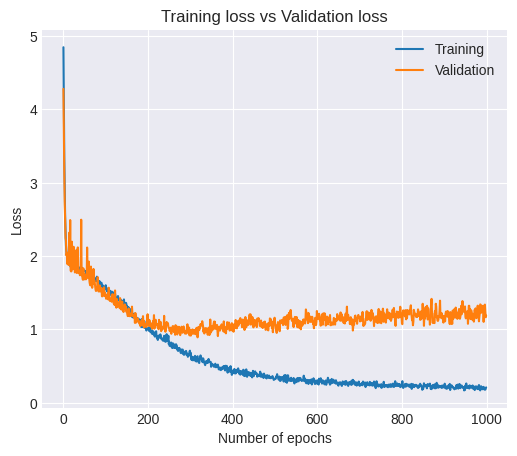

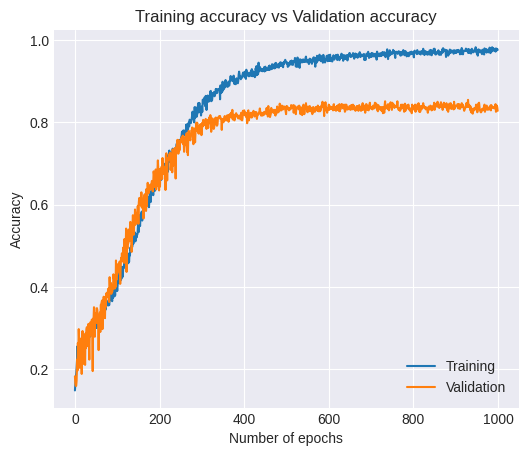

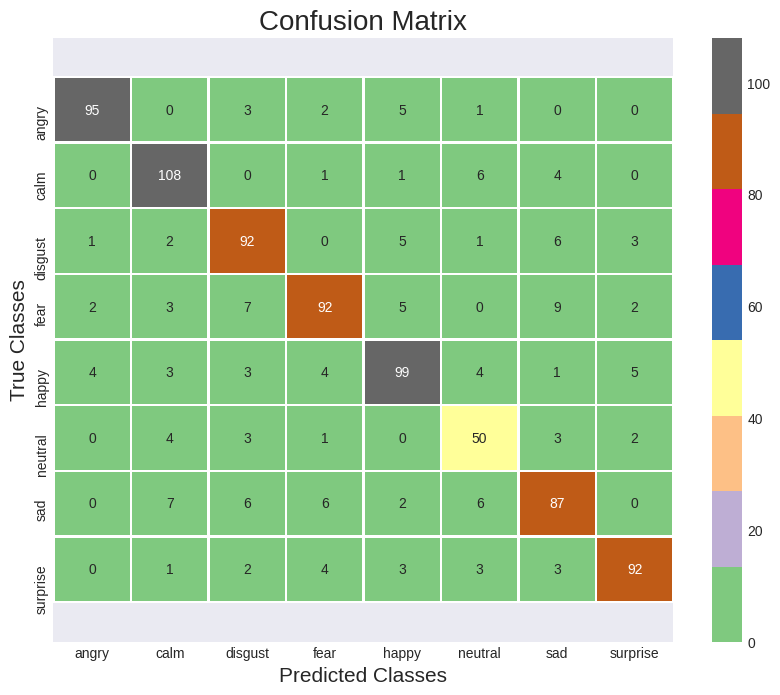

In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (10, 8))
plt.rcParams['figure.dpi'] = 200 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-CHROMA.png')
plt.show() 

In [ ]:
#New

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 155, 256)          2304      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 74, 256)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 256)           1024      
_________________________________________________________________
dropout (Dropout)            (None, 74, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 37, 256)           0

45/45 [==============================] - 0s 6ms/step - loss: 0.5041 - accuracy: 0.9368
Loss of the model is -  0.5041433572769165
45/45 [==============================] - 0s 5ms/step - loss: 0.5041 - accuracy: 0.9368
Accuracy of the model is -  93.68055462837219 %


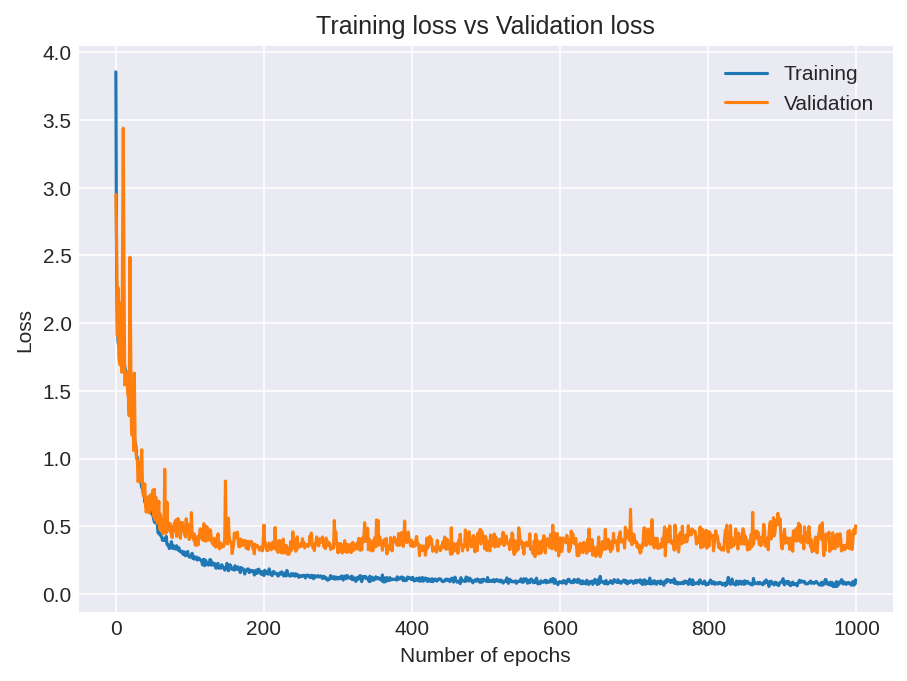

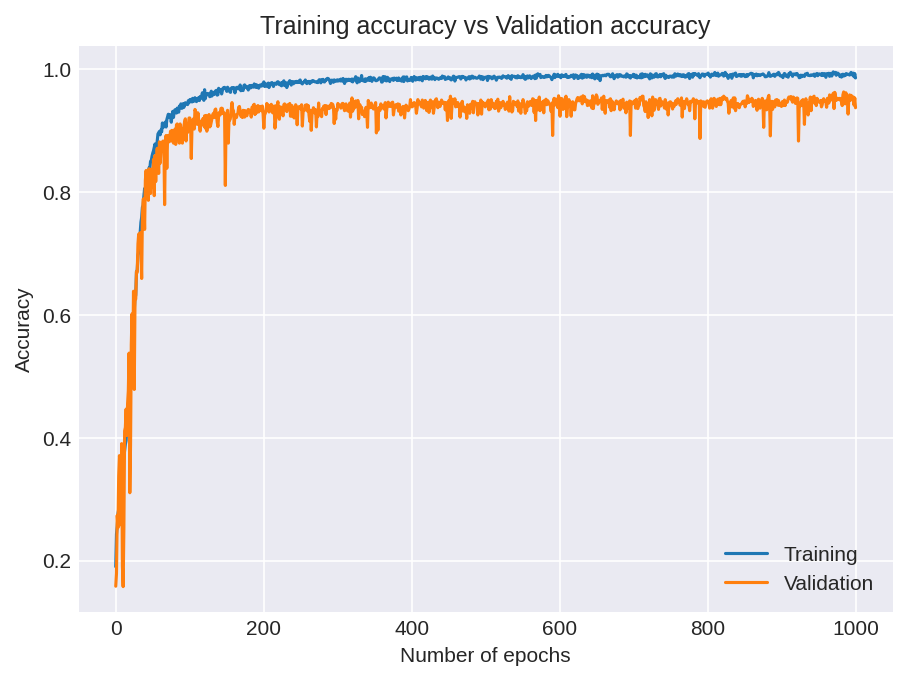

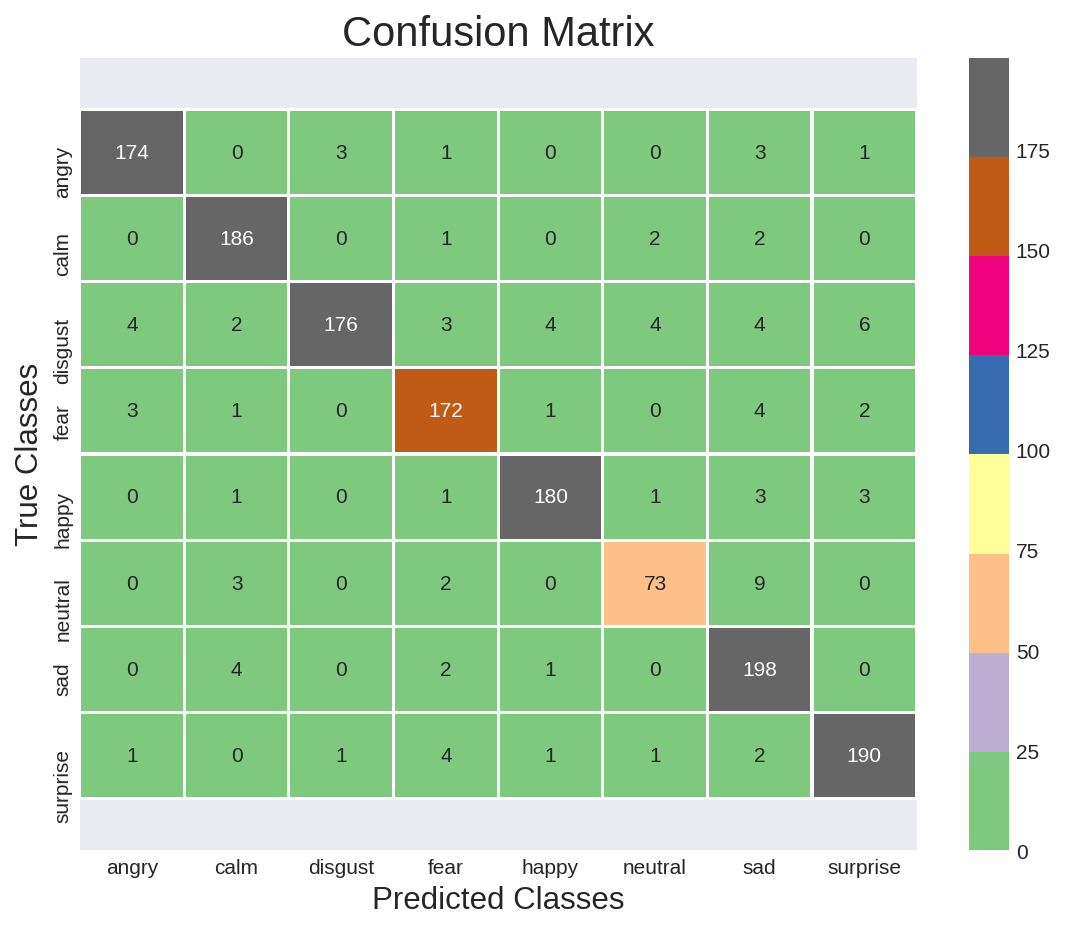

              precision    recall  f1-score   support

       angry       0.96      0.96      0.96       182
        calm       0.94      0.97      0.96       191
     disgust       0.98      0.87      0.92       203
        fear       0.92      0.94      0.93       183
       happy       0.96      0.95      0.96       189
     neutral       0.90      0.84      0.87        87
         sad       0.88      0.97      0.92       205
    surprise       0.94      0.95      0.95       200

    accuracy                           0.94      1440
   macro avg       0.94      0.93      0.93      1440
weighted avg       0.94      0.94      0.94      1440



In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise']))

In [17]:
#ENSEMBLE

In [26]:
#MODEL1
model1 = tf.keras.Sequential()
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.5))
model1.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.5))
model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(8, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model1.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model1.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
model1.save('saved_models/model1-ravdess.hdf5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 155, 256)          2304      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 74, 256)           1024      
_________________________________________________________________
dropout_9 (Dropout)          (None, 74, 256)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 37, 256)          

45/45 [==============================] - 0s 7ms/step - loss: 0.4383 - accuracy: 0.9438
Loss of the model is -  0.4382777810096741
45/45 [==============================] - 0s 7ms/step - loss: 0.4383 - accuracy: 0.9438
Accuracy of the model is -  94.37500238418579 %


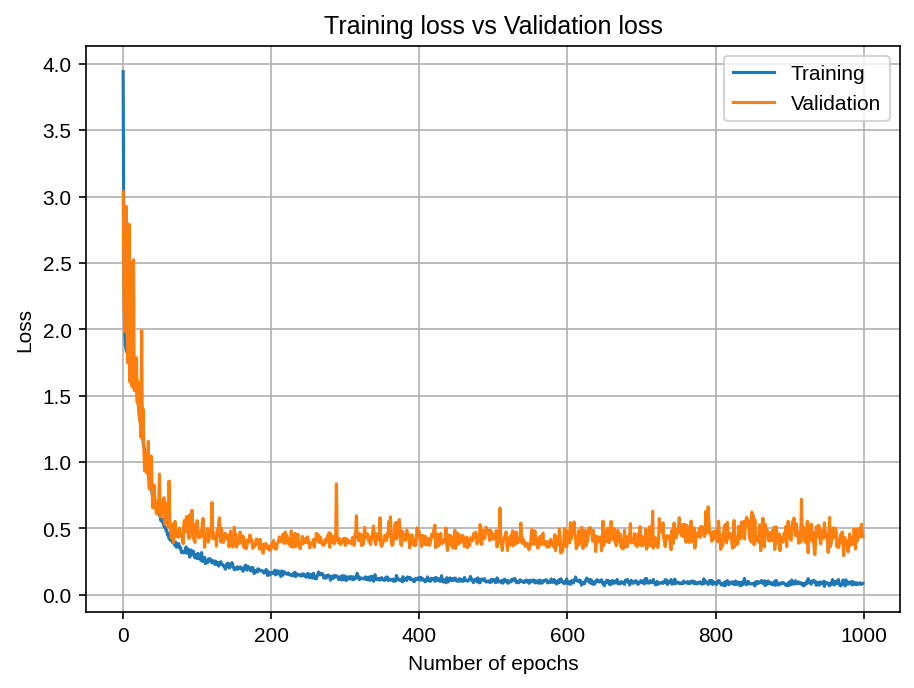

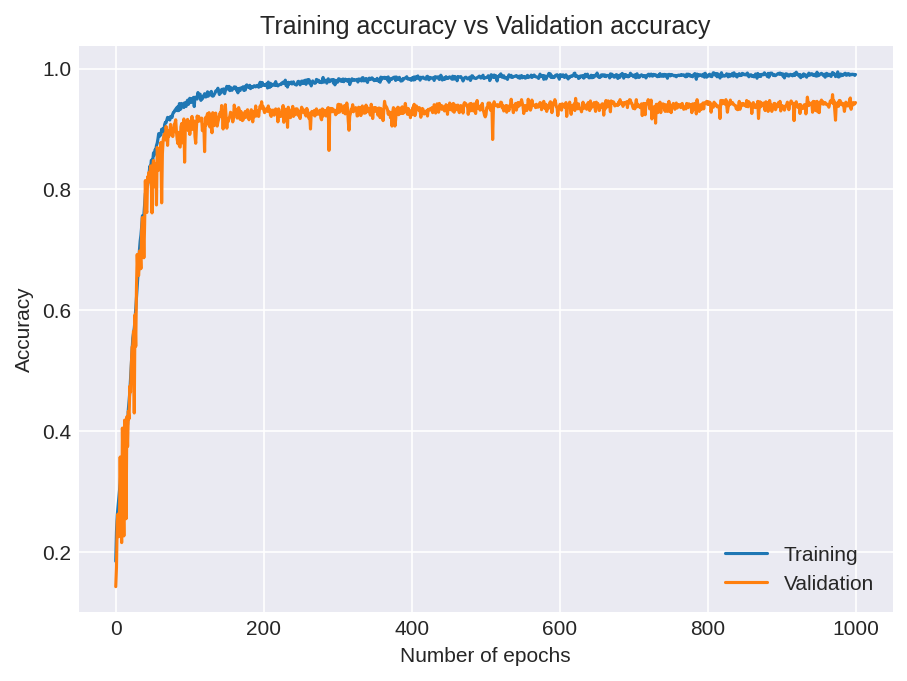

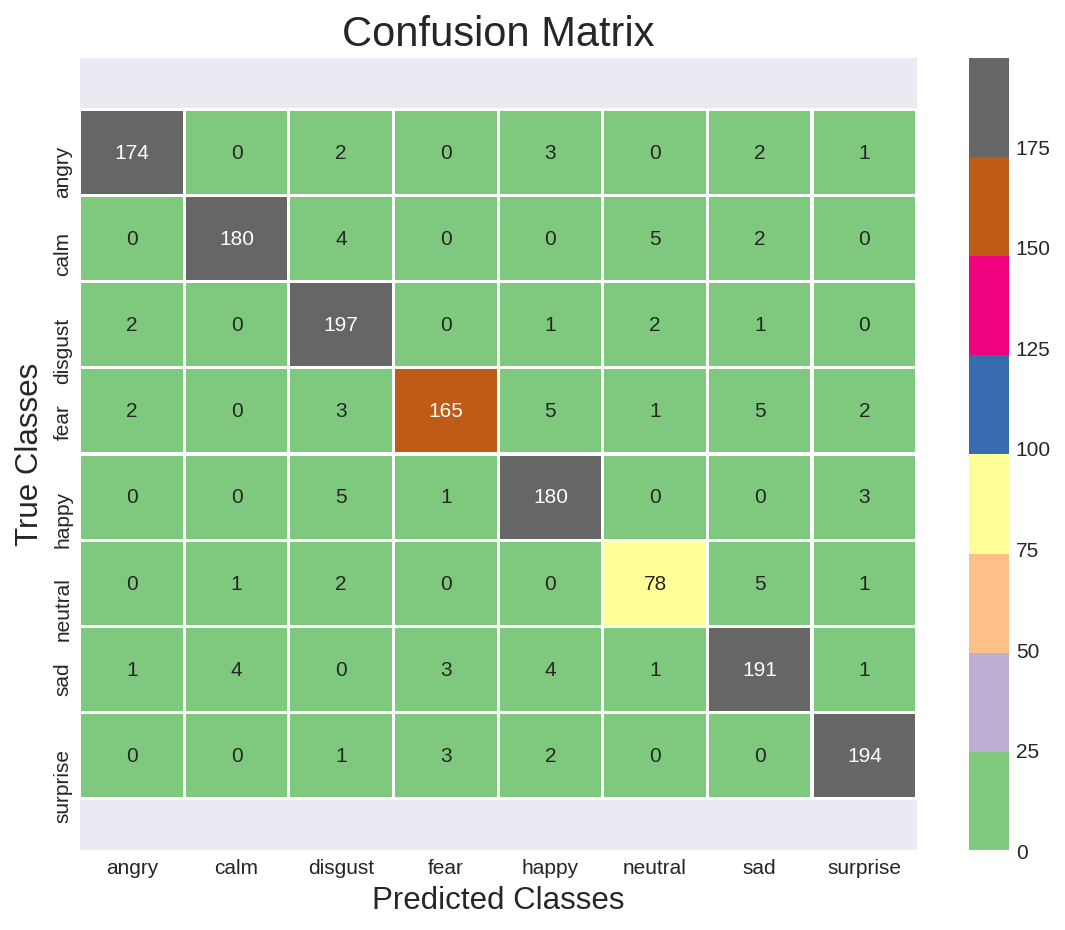

              precision    recall  f1-score   support

       angry       0.97      0.96      0.96       182
        calm       0.97      0.94      0.96       191
     disgust       0.92      0.97      0.94       203
        fear       0.96      0.90      0.93       183
       happy       0.92      0.95      0.94       189
     neutral       0.90      0.90      0.90        87
         sad       0.93      0.93      0.93       205
    surprise       0.96      0.97      0.97       200

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



In [27]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss'] 
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model1.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model1.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model1.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('ravdess-model1.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise']))

In [28]:
#MODEL2
model2 = tf.keras.Sequential()
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.GRU(512))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(8, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model2.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model2.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
model2.save('saved_models/model2-ravdess.hdf5') 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 155, 256)          2304      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 74, 256)           1024      
_________________________________________________________________
dropout_18 (Dropout)         (None, 74, 256)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 37, 256)          

45/45 [==============================] - 0s 7ms/step - loss: 0.6691 - accuracy: 0.9361
Loss of the model is -  0.66908198595047
45/45 [==============================] - 0s 7ms/step - loss: 0.6691 - accuracy: 0.9361
Accuracy of the model is -  93.61110925674438 %


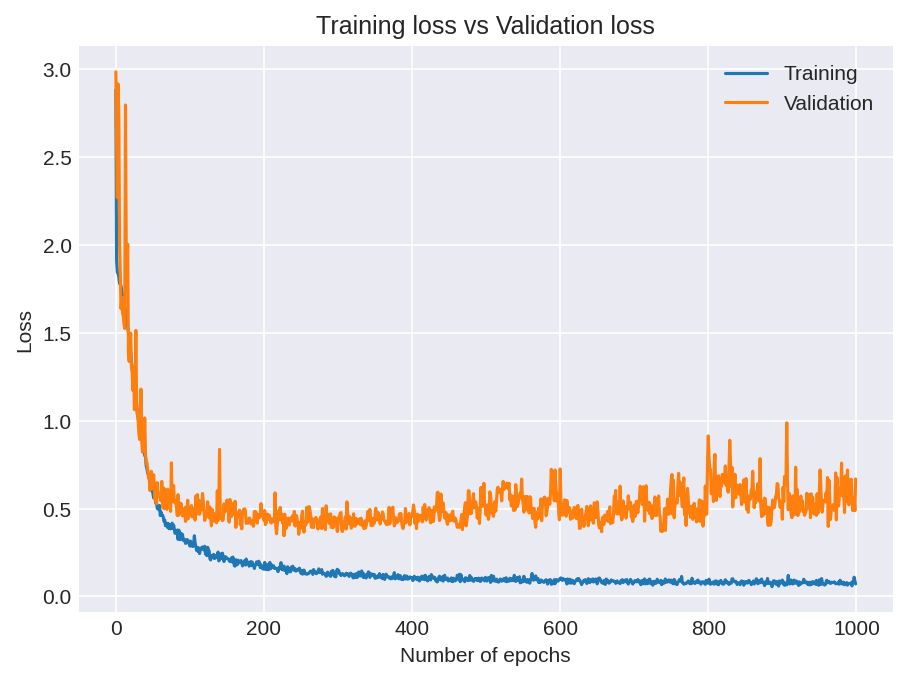

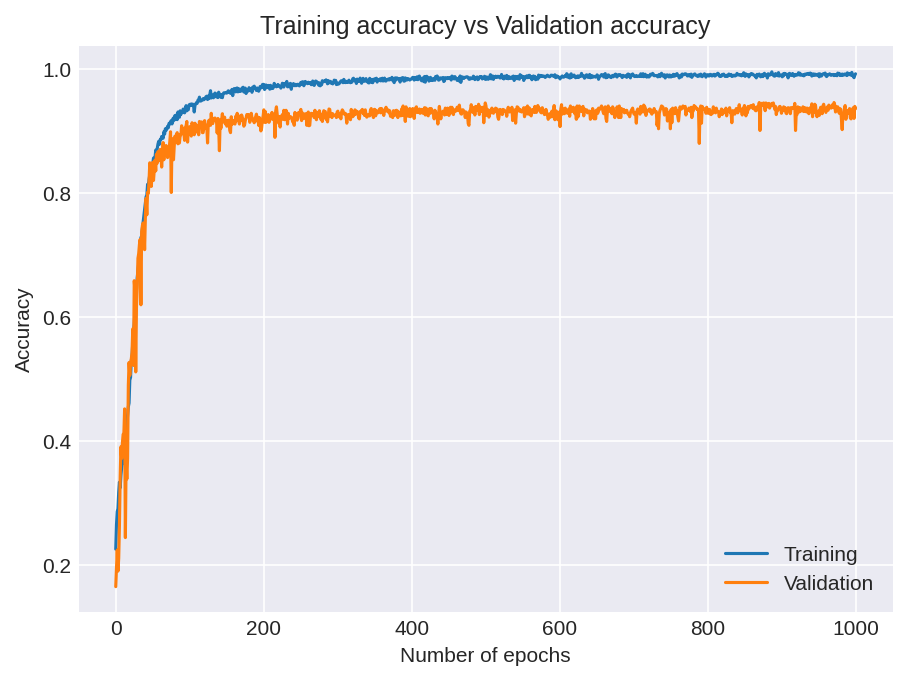

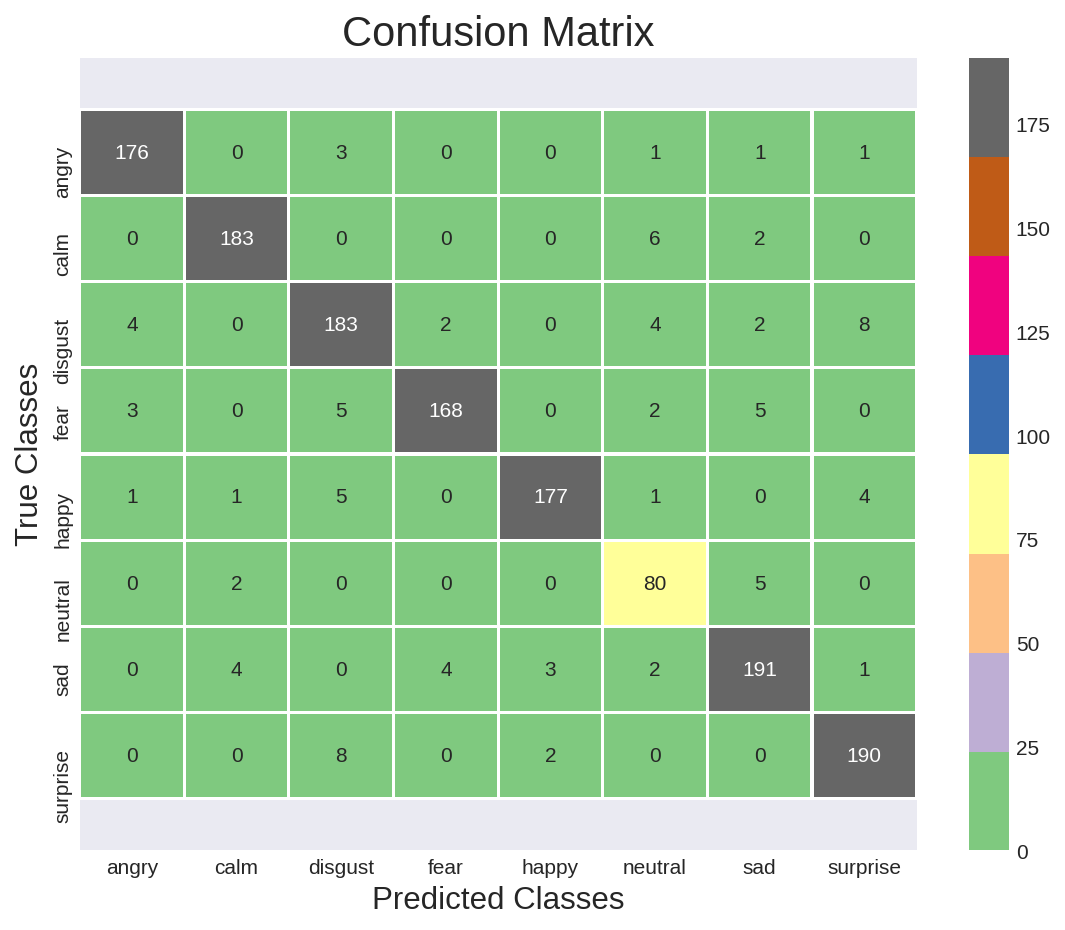

              precision    recall  f1-score   support

       angry       0.96      0.97      0.96       182
        calm       0.96      0.96      0.96       191
     disgust       0.90      0.90      0.90       203
        fear       0.97      0.92      0.94       183
       happy       0.97      0.94      0.95       189
     neutral       0.83      0.92      0.87        87
         sad       0.93      0.93      0.93       205
    surprise       0.93      0.95      0.94       200

    accuracy                           0.94      1440
   macro avg       0.93      0.94      0.93      1440
weighted avg       0.94      0.94      0.94      1440



In [29]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))  
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model2.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('ravdess-model1.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise']))

In [30]:
#MODEL3
model3 = tf.keras.Sequential()
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(layers.MaxPooling1D(pool_size=(2))) 
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization()) 
model3.add(layers.Dropout(0.25))  
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.LSTM(512))
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(8, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model3.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model3.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
model3.save('saved_models/model3-ravdess.hdf5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 155, 256)          2304      
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 74, 256)           1024      
_________________________________________________________________
dropout_27 (Dropout)         (None, 74, 256)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 37, 256)          

45/45 [==============================] - 0s 7ms/step - loss: 0.4153 - accuracy: 0.9361
Loss of the model is -  0.4153017997741699
45/45 [==============================] - 0s 8ms/step - loss: 0.4153 - accuracy: 0.9361
Accuracy of the model is -  93.61110925674438 %


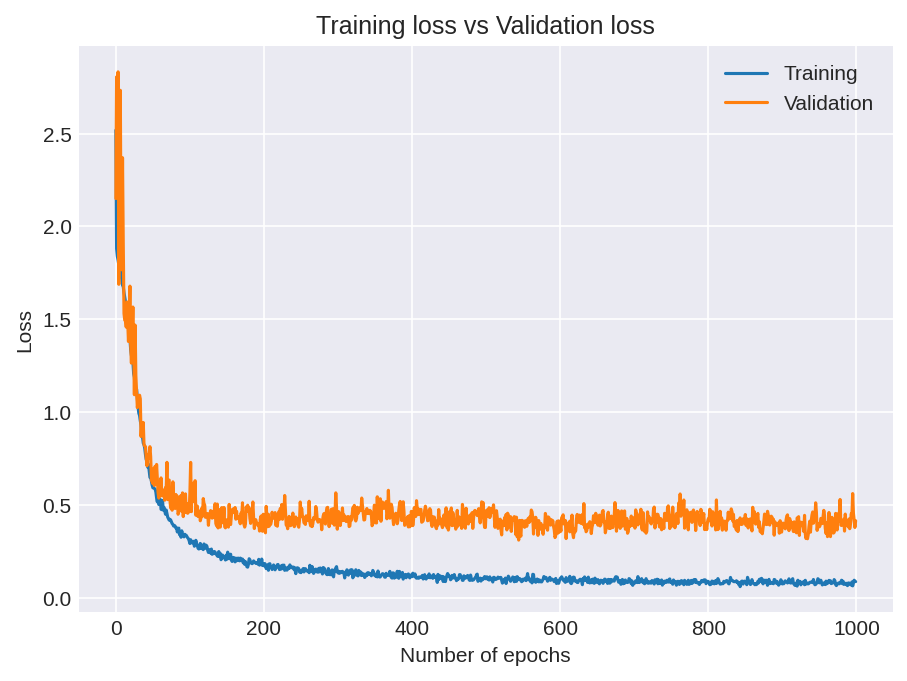

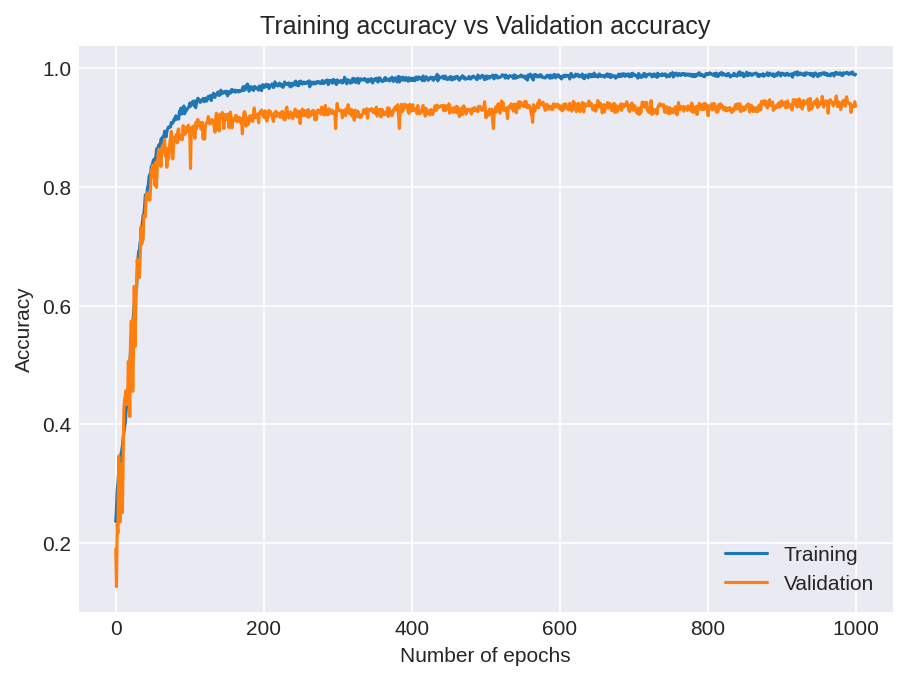

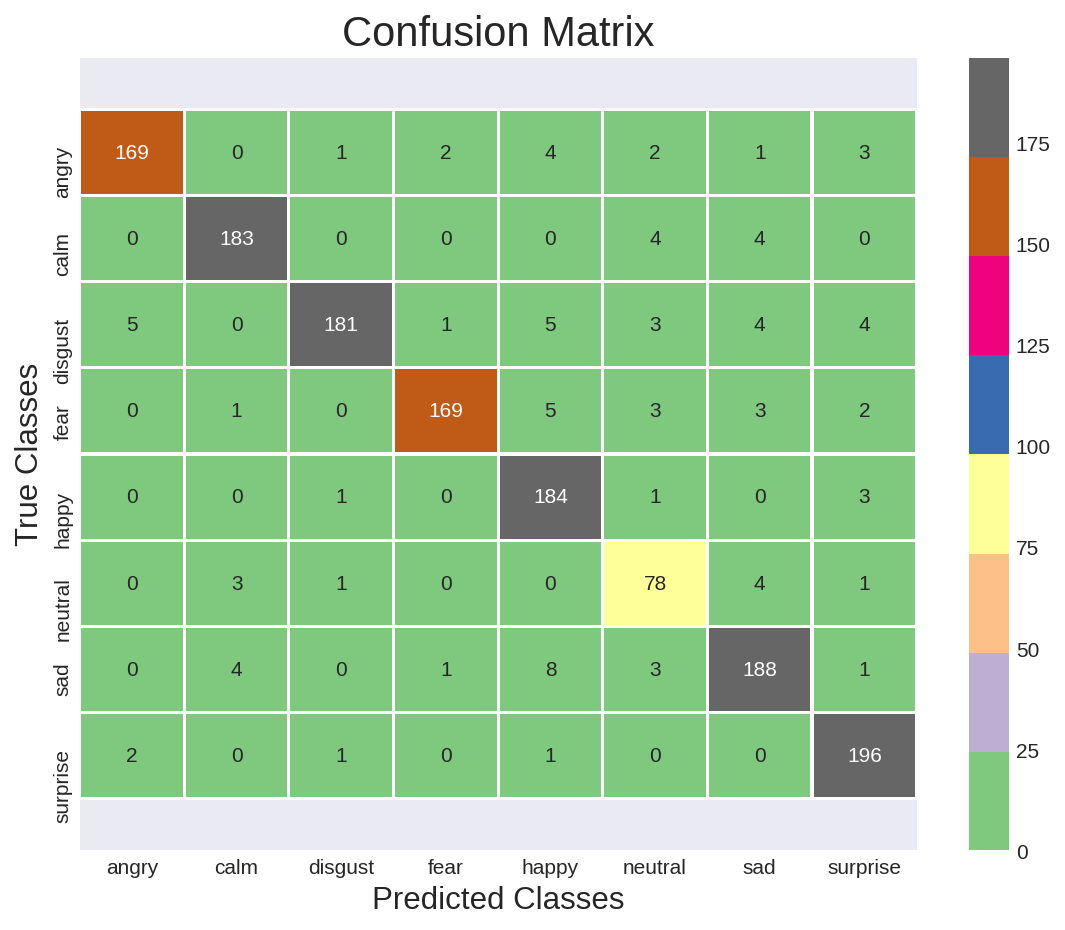

              precision    recall  f1-score   support

       angry       0.96      0.93      0.94       182
        calm       0.96      0.96      0.96       191
     disgust       0.98      0.89      0.93       203
        fear       0.98      0.92      0.95       183
       happy       0.89      0.97      0.93       189
     neutral       0.83      0.90      0.86        87
         sad       0.92      0.92      0.92       205
    surprise       0.93      0.98      0.96       200

    accuracy                           0.94      1440
   macro avg       0.93      0.93      0.93      1440
weighted avg       0.94      0.94      0.94      1440



In [31]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy'] 
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model3.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model3.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model3.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('ravdess-model1.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy Score for model1 =  0.94375
Accuracy Score for model2 =  0.9361111111111111
Accuracy Score for model3 =  0.9361111111111111
Accuracy Score for average ensemble =  0.9534722222222223
Weighted average method
Accuracy Score for model1 =  0.94375
Accuracy Score for model2 =  0.9361111111111111
Accuracy Score for model3 =  0.9361111111111111
Accuracy Score for average ensemble =  0.9534722222222223
Accuracy Score for weighted average ensemble =  0.9534722222222223
Max accuracy of  95.625  obained with w1= 0.4  w2= 0.3  and w3= 0.2


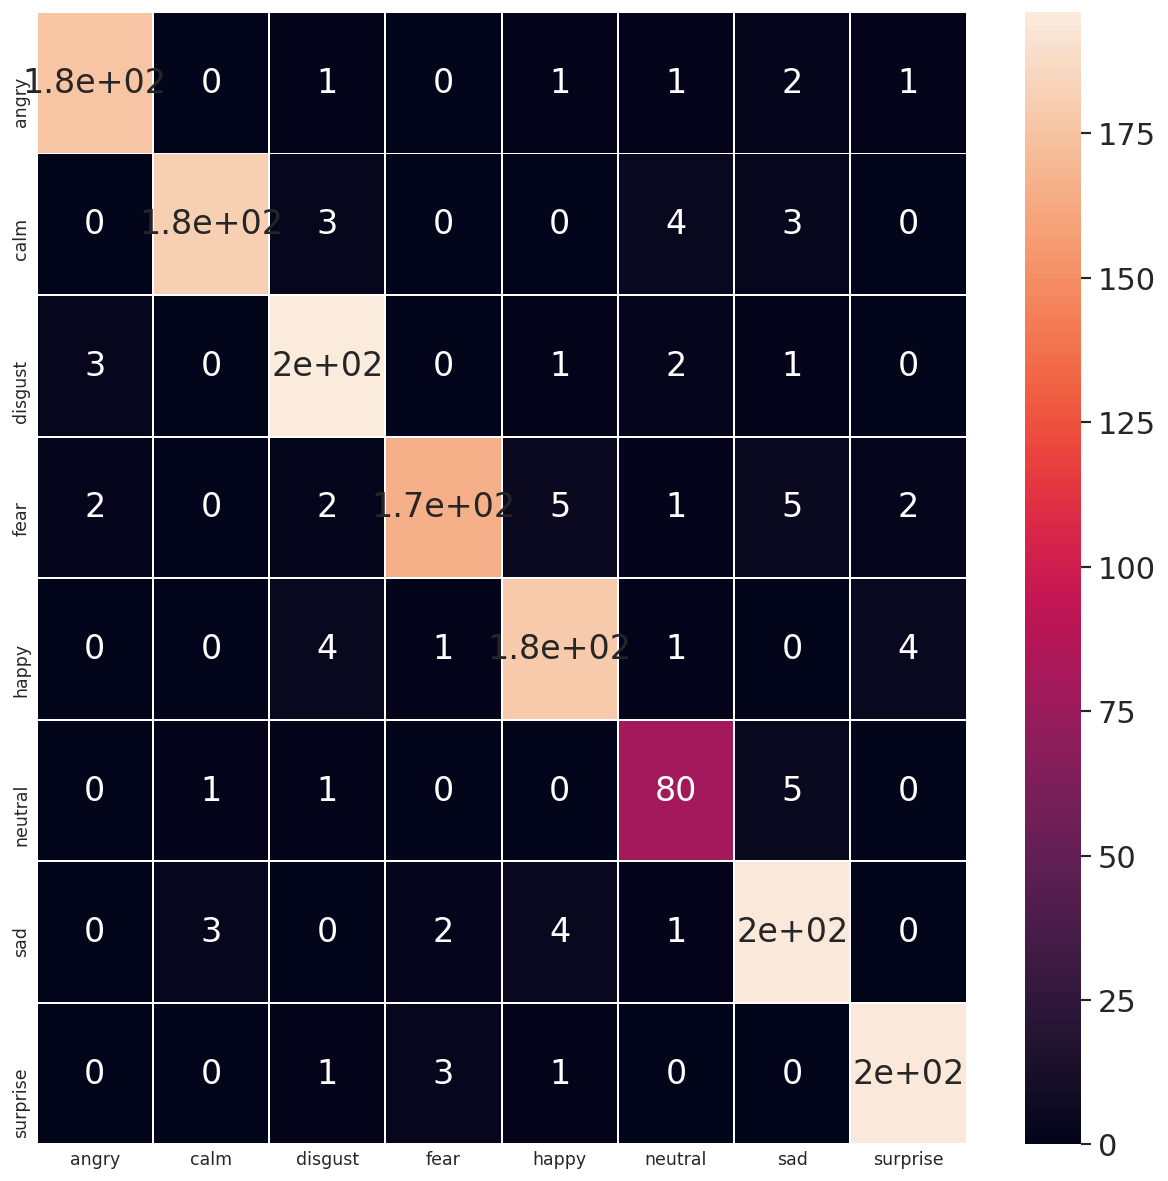

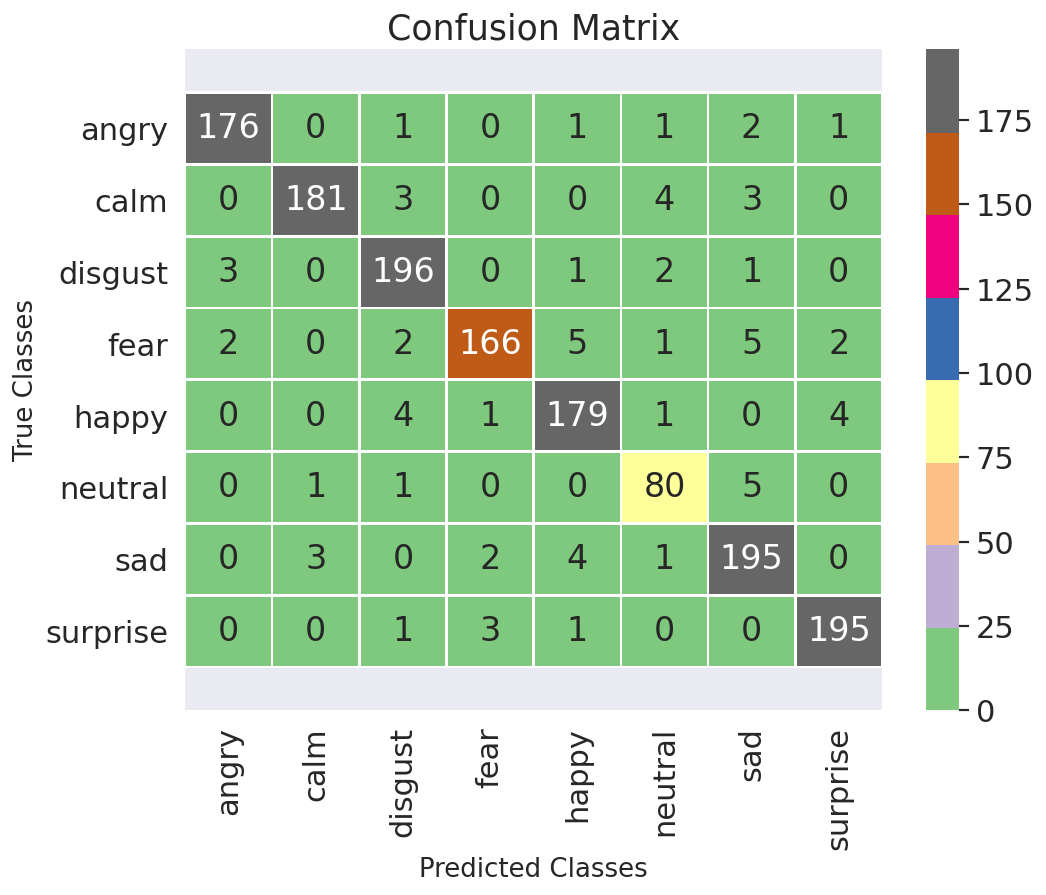

In [32]:
import random
#########################################################################
### Model average / sum Ensemble
# Simple sum of all outputs / predictions and argmax across all classes
########
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('saved_models/model1-ravdess.hdf5')
model2 = load_model('saved_models/model2-ravdess.hdf5')
model3 = load_model('saved_models/model3-ravdess.hdf5')

models = [model1, model2, model3]

preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict_classes(x_test)
prediction2 = model2.predict_classes(x_test)
prediction3 = model3.predict_classes(x_test)

accuracy1 = accuracy_score(np.argmax(y_test, axis=1), prediction1)
accuracy2 = accuracy_score(np.argmax(y_test, axis=1), prediction2)
accuracy3 = accuracy_score(np.argmax(y_test, axis=1), prediction3)
ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

########################################
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
weights = [0.4, 0.2, 0.4]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)
print('Weighted average method')
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

########################################
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2, model3]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " and w3=", max_acc_row[2])         




###########################################################################
### Explore metrics for the ideal weighted ensemble model. 

models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [0.4, 0.1, 0.2] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



from sklearn.metrics import confusion_matrix
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db-model-2.png')
plt.show() 

In [2]:
########################################
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
weights = [0.4, 0.2, 0.4]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)
print('Weighted average method')
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

NameError: ignored